In [4]:
from src.proby.lib_dp import create_dg, Probe, get_polynomial, GameEnd, evaluate_graph, evaluate_graph_float
from typing import NamedTuple
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class GameScore(NamedTuple):
    p1: int
    p2: int
    p1_serving: bool

init_game = GameScore(p1=0, p2=0, p1_serving=True)
def play_game(score: GameScore, p: Probe, q: Probe) -> GameScore | GameEnd:
    sp = p if score.p1_serving else q
    if sp.run():
        score = GameScore(p1=score.p1 + 1, p2=score.p2, p1_serving=score.p1_serving)
    else:
        score = GameScore(p1=score.p1, p2=score.p2 + 1, p1_serving=score.p1_serving)
    if score.p1 == score.p2 == 3:
        score = GameScore(p1=2, p2=2, p1_serving=score.p1_serving)
    if max(score.p1, score.p2) == 4:
        return GameEnd.WIN if score.p1 > score.p2 else GameEnd.LOSE
    return score

N = 3
class TieBreakScore(NamedTuple):
    p1: int
    p2: int
    p1_serving: bool
init_tie_break=TieBreakScore(p1=0, p2=0, p1_serving=True)
def play_tie_break(score: TieBreakScore, p: Probe, q: Probe) -> TieBreakScore | GameEnd:
    sp = p if score.p1_serving else q
    if sp.run():
        score = TieBreakScore(p1=score.p1 + 1, p2=score.p2, p1_serving=score.p1_serving)
    else:
        score = TieBreakScore(p1=score.p1, p2=score.p2 + 1, p1_serving=score.p1_serving)
    if score.p1 + score.p2 % 2 == 0:
        score = TieBreakScore(p1=score.p1, p2=score.p2, p1_serving=not score.p1_serving)
    if score.p1 == score.p2 == N - 1:
        score = GameScore(p1=N - 2, p2=N - 2, p1_serving=score.p1_serving)
    if max(score.p1, score.p2) == N:
        return GameEnd.WIN if score.p1 > score.p2 else GameEnd.LOSE
    return score

def play_game(score: GameScore, p: Probe, q: Probe) -> GameScore | GameEnd:
    sp = p if score.p1_serving else q
    if sp.run():
        score = GameScore(p1=score.p1 + 1, p2=score.p2, p1_serving=score.p1_serving)
    else:
        score = GameScore(p1=score.p1, p2=score.p2 + 1, p1_serving=score.p1_serving)
    if max(score.p1, score.p2) == 4:
        return GameEnd.WIN if score.p1 > score.p2 else GameEnd.LOSE
    return score


class SetScore(NamedTuple):
    p1: int
    p2: int
    current_game: GameScore
    tie_break: TieBreakScore
def play_set(score: SetScore, p: Probe, q: Probe) -> GameScore | GameEnd:
    if score.p1 == score.p2 == 6:
        new_set_score = play_tie_break(score=score.tie_break, p=p, q=q)
        if new_set_score in [GameEnd.WIN, GameEnd.LOSE]:
            return new_set_score
        else:
            return SetScore(p1=score.p1, p2=score.p2, current_game=score.current_game, tie_break=new_set_score)
    else:
        current_game = play_game(score=score.current_game, p=p, q=q)
        if current_game == GameEnd.WIN:
            score = SetScore(p1=score.p1 + 1, p2=score.p2, current_game=GameScore(p1=0, p2=0, p1_serving=not score.current_game.p1_serving), tie_break=score.tie_break)
        elif current_game == GameEnd.LOSE:
            score = SetScore(p1=score.p1, p2=score.p2 + 1, current_game=GameScore(p1=0, p2=0, p1_serving=not score.current_game.p1_serving), tie_break=score.tie_break)
        else:
            score = SetScore(p1=score.p1, p2=score.p2, current_game=current_game, tie_break=score.tie_break)
        if max(score.p1, score.p2) >= 6 and  abs(score.p1 - score.p2) > 1:
            return GameEnd.WIN if score.p1 > score.p2 else GameEnd.LOSE
        return score

init_set = SetScore(p1=0, p2=0, current_game=GameScore(p1=0, p2=0, p1_serving=True), tie_break=TieBreakScore(p1=0, p2=0, p1_serving=True))

class MatchScore(NamedTuple):
    p1: int
    p2: int
    current_set: SetScore
def play_match(score: MatchScore, p: Probe, q: Probe) -> MatchScore | GameEnd:
    new_set_score = play_set(score=score.current_set, p=p, q=q)
    if new_set_score == GameEnd.WIN:
        score=MatchScore(p1=score.p1 + 1, p2=score.p2, current_set=init_set)
    elif new_set_score == GameEnd.LOSE:
        score=MatchScore(p1=score.p1, p2=score.p2 + 1, current_set=init_set)
    else:
        score=MatchScore(p1=score.p1, p2=score.p2, current_set=new_set_score)
    if score.p1 == 2:
        return GameEnd.WIN
    if score.p2 == 2:
        return GameEnd.LOSE
    return score
init_match = MatchScore(p1=0, p2=0,current_set=init_set)

dg = create_dg(init_match, play_fn=play_match)

In [77]:
def print_dg(dg):
    out = ""
    for state in dg:
        out += str(state) + "\n"
        for k in dg[state]:
            out += "    * " + str(dg[state][k]) + "\n"
    return out
print(print_dg(dg))

MatchScore(p1=0, p2=0, current_set=SetScore(p1=0, p2=0, current_game=GameScore(p1=0, p2=0, p1_serving=True), tie_break=TieBreakScore(p1=0, p2=0, p1_serving=True)))
    * MatchScore(p1=0, p2=0, current_set=SetScore(p1=0, p2=0, current_game=GameScore(p1=1, p2=0, p1_serving=True), tie_break=TieBreakScore(p1=0, p2=0, p1_serving=True)))
    * MatchScore(p1=0, p2=0, current_set=SetScore(p1=0, p2=0, current_game=GameScore(p1=0, p2=1, p1_serving=True), tie_break=TieBreakScore(p1=0, p2=0, p1_serving=True)))
MatchScore(p1=0, p2=0, current_set=SetScore(p1=0, p2=0, current_game=GameScore(p1=1, p2=0, p1_serving=True), tie_break=TieBreakScore(p1=0, p2=0, p1_serving=True)))
    * MatchScore(p1=0, p2=0, current_set=SetScore(p1=0, p2=0, current_game=GameScore(p1=2, p2=0, p1_serving=True), tie_break=TieBreakScore(p1=0, p2=0, p1_serving=True)))
    * MatchScore(p1=0, p2=0, current_set=SetScore(p1=0, p2=0, current_game=GameScore(p1=1, p2=1, p1_serving=True), tie_break=TieBreakScore(p1=0, p2=0, p1_serving=

TieBreakScore(p1=0, p2=0, p1_serving=True)
    * TieBreakScore(p1=1, p2=0, p1_serving=True)
    * TieBreakScore(p1=0, p2=1, p1_serving=True)
TieBreakScore(p1=0, p2=1, p1_serving=True)
    * TieBreakScore(p1=1, p2=1, p1_serving=True)
    * TieBreakScore(p1=0, p2=2, p1_serving=False)
TieBreakScore(p1=0, p2=2, p1_serving=False)
    * TieBreakScore(p1=1, p2=2, p1_serving=False)
    * TieBreakScore(p1=0, p2=3, p1_serving=False)
TieBreakScore(p1=0, p2=3, p1_serving=False)
    * TieBreakScore(p1=1, p2=3, p1_serving=False)
    * TieBreakScore(p1=0, p2=4, p1_serving=True)
TieBreakScore(p1=1, p2=1, p1_serving=True)
    * TieBreakScore(p1=2, p2=1, p1_serving=True)
    * TieBreakScore(p1=1, p2=2, p1_serving=True)
TieBreakScore(p1=1, p2=2, p1_serving=True)
    * TieBreakScore(p1=2, p2=2, p1_serving=True)
    * TieBreakScore(p1=1, p2=3, p1_serving=True)
TieBreakScore(p1=2, p2=1, p1_serving=True)
    * TieBreakScore(p1=3, p2=1, p1_serving=True)
    * TieBreakScore(p1=2, p2=2, p1_serving=True)
TieBrea

np.float64(2.951593230260341)

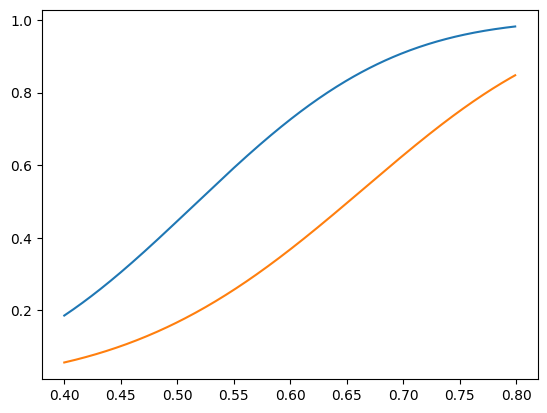

In [80]:
m = play_tie_break
init = init_tie_break
dg = create_dg(score=init_tie_break, play_fn=play_tie_break)
print(print_dg(dg))
step = 0.001
mean_ps=np.arange(-.2,.2,step)
ps = mean_ps + 0.60
qs = mean_ps + 0.40
dg = create_dg(init, play_fn=m)
vs = evaluate_graph_float(dg, init, p=ps, q=qs)
plt.plot(ps, vs)
vs2 = evaluate_graph_float(dg, init, p=qs, q=ps)
plt.plot(ps, vs2)
max(np.diff(vs)/step)

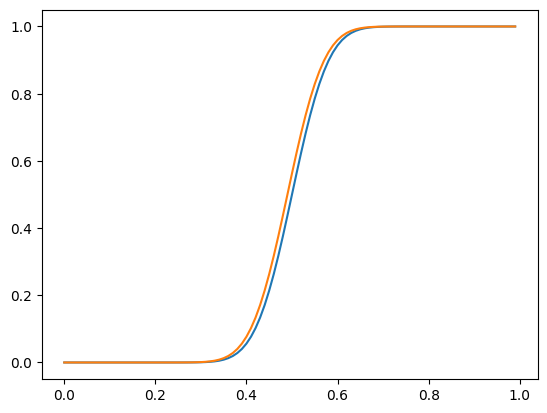

In [52]:
dg = create_dg(init_set, play_fn=play_set)
v2_n = evaluate_graph_float(dg, init_set, p=np.arange(0,1,.01), q=np.arange(0,1,.01))
plt.plot(np.arange(0,1,.01), v2_n)
plt.plot(np.arange(0,1,.01)[::-1], 1-v2_n)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


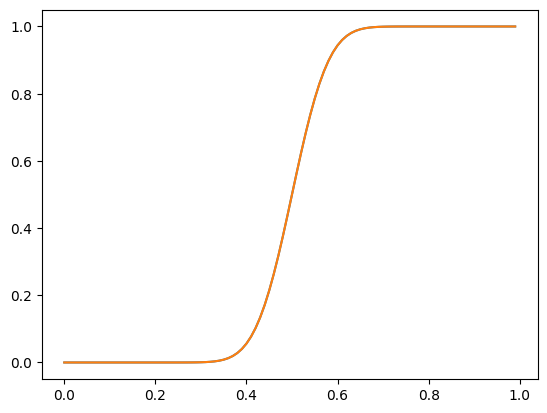

In [59]:
ps = np.arange(0,1,.01)
print(ps)
vs = evaluate_graph_float(dg, init_set, p=ps, q=ps)
plt.plot(ps, vs)
vs2 = evaluate_graph_float(dg, init_set, p=1-ps, q=1-ps)
plt.plot(ps, 1-vs2)

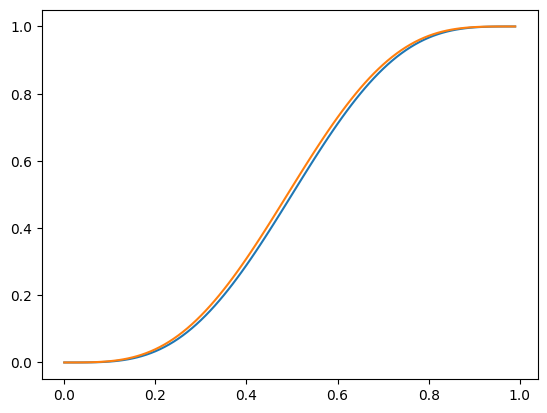

In [47]:
dg = create_dg(init_game, play_fn=play_game)
v2_n = evaluate_graph_float(dg, init_game, p=np.arange(0,1,.01), q=np.arange(0,1,.01))
plt.plot(np.arange(0,1,.01), v2_n)
plt.plot(np.arange(0,1,.01), 1-v2_n[::-1])

In [42]:
print(print_dg(dg))

GameScore(p1=0, p2=0, p1_serving=True)
    * GameScore(p1=1, p2=0, p1_serving=True)
    * GameScore(p1=0, p2=1, p1_serving=True)
GameScore(p1=0, p2=1, p1_serving=True)
    * GameScore(p1=1, p2=1, p1_serving=True)
    * GameScore(p1=0, p2=2, p1_serving=True)
GameScore(p1=1, p2=1, p1_serving=True)
    * GameScore(p1=2, p2=1, p1_serving=True)
    * GameScore(p1=1, p2=2, p1_serving=True)
GameScore(p1=1, p2=2, p1_serving=True)
    * GameScore(p1=2, p2=2, p1_serving=True)
    * GameScore(p1=1, p2=3, p1_serving=True)
GameScore(p1=0, p2=2, p1_serving=True)
    * GameScore(p1=1, p2=2, p1_serving=True)
    * GameScore(p1=0, p2=3, p1_serving=True)
GameScore(p1=1, p2=0, p1_serving=True)
    * GameScore(p1=2, p2=0, p1_serving=True)
    * GameScore(p1=1, p2=1, p1_serving=True)
GameScore(p1=2, p2=1, p1_serving=True)
    * GameScore(p1=3, p2=1, p1_serving=True)
    * GameScore(p1=2, p2=2, p1_serving=True)
GameScore(p1=0, p2=3, p1_serving=True)
    * GameScore(p1=1, p2=3, p1_serving=True)
    * GameEnd

In [ ]:


# Define the score structure for match, set, and game
Score = namedtuple('Score', ['sets', 'games_p1', 'games_p2', 'points_p1', 'points_p2'])

# Represents the state of a match
def play_match(score: Score, p: Probe, q: Probe) -> tuple | GameEnd:
    def play_game(player_p, player_q, score):
        # Play a game between two players (p1 and p2), with their probes passed
        while True:
            # Determine which player is active
            sp = player_p if ((score.points_p1 + score.points_p2) % 2 == 0) else player_q
            
            # Run the active player's probe to decide if they win the point
            if sp.run():
                score = Score(score.sets, score.games_p1 + 1, score.games_p2, score.points_p1 + 1, score.points_p2)
            else:
                score = Score(score.sets, score.games_p1, score.games_p2 + 1, score.points_p1, score.points_p2 + 1)
            
            # Check if a player has won the game (winning player needs 4 points and at least 2 more than opponent)
            if score.points_p1 >= 4 and score.points_p1 - score.points_p2 >= 2:
                return Score(score.sets, score.games_p1 + 1, score.games_p2, 0, 0)
            elif score.points_p2 >= 4 and score.points_p2 - score.points_p1 >= 2:
                return Score(score.sets, score.games_p1, score.games_p2 + 1, 0, 0)
    
    def play_set(player_p, player_q, score):
        # Play a set between two players, passing their probes
        while True:
            # If score reaches 6-6, we play a tiebreak
            if score.games_p1 == 6 and score.games_p2 == 6:
                score = play_tiebreak(player_p, player_q, score)
                return score
            # Normal game play
            score = play_game(player_p, player_q, score)
            
            # Check if someone won the set
            if score.games_p1 == 6:
                return Score(score.sets, 0, 0, score.points_p1, score.points_p2)
            elif score.games_p2 == 6:
                return Score(score.sets, 0, 0, score.points_p1, score.points_p2)
    
    def play_tiebreak(player_p, player_q, score):
        # Play a tiebreaker game (first to 7 points, with 2-point lead), passing their probes
        score = Score(score.sets, score.games_p1, score.games_p2, 0, 0)
        while True:
            # Determine which player is active in the tiebreak
            sp = player_p if ((score.points_p1 + score.points_p2) % 2 == 0) else player_q
            
            # Run the active player's probe to decide if they win the point
            if sp.run():
                score = Score(score.sets, score.games_p1, score.games_p2, score.points_p1 + 1, score.points_p2)
            else:
                score = Score(score.sets, score.games_p1, score.games_p2, score.points_p1, score.points_p2 + 1)

            # Check if tiebreaker has a winner (7 points, 2-point margin)
            if score.points_p1 >= 7 and score.points_p1 - score.points_p2 >= 2:
                return Score(score.sets + 1, score.games_p1 + 1, score.games_p2, 0, 0)
            elif score.points_p2 >= 7 and score.points_p2 - score.points_p1 >= 2:
                return Score(score.sets + 1, score.games_p1, score.games_p2 + 1, 0, 0)
    
    # Main loop for playing the match (best of 2 sets)
    while True:
        # Play a set, passing the probes for each player
        score = play_set(p, q, score)

        # Check if match has a winner (first player to win 2 sets wins)
        if score.sets == 2:
            if score.games_p1 > score.games_p2:
                return GameEnd.WIN
            else:
                return GameEnd.LOSE
        # If not, proceed to next set (reset game scores for next set)
        score = Score(score.sets + 1, 0, 0, 0, 0)


initial_score = Score(sets=0, games_p1=0, games_p2=0, points_p1=0, points_p2=0)

In [5]:
dg = create_dg(initial_score, play_match)


KeyboardInterrupt



In [37]:
@point
def tp1(x):
    return True

@point
def tp2(x):
    return False


@point
def tie_break(x):
    pp = [0, 0]
    i = 0
    while max(pp) < 11:
        i += 1
        if (i//2) % 2:
            pp[tp2(x)] += 1
        else:
            pp[tp1(x)] += 1
    return pp[1] > pp[0]

@point
def tie_break_advantages(x):
    pp = [0, 0]
    i = 0
    while max(pp) < 7 or abs(pp[0] - pp[1]) < 2:
        i += 1
        if (i//2) % 2:
            pp[tp2(x)] += 1
        else:
            pp[tp1(x)] += 1

        if max(pp) > 12:
            break
    return pp[1] > pp[0]
tie_break.compute_tree()

In [38]:
tp2.probability(base_point={})

0.0

In [41]:
1==1==1

True

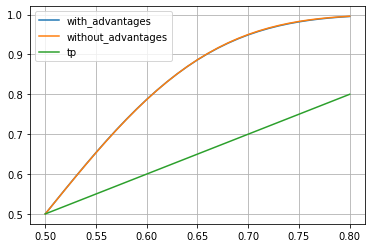

In [45]:
ps = np.arange(0.5, 0.8, 0.01)
def logit(x):
    return np.log(np.abs(x/(1-x)))
for P in [with_advantages, without_advantages, tp]:
    plt.plot(ps, abs(np.array([P.probability(base_point={tp: p}) for p in ps])), label=P)
plt.legend()
plt.grid()

In [14]:
i = 0
while i<10:
    i += 1
    print((i//2) % 2)

0
1
1
0
0
1
1
0
0
1
